In [1]:
import os
import numpy as np
import pandas as pd
import piplite

await piplite.install('seaborn')
await piplite.install('plotly')

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import seaborn as sns
import scipy as sp
import plotly.express as px
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.datasets import fetch_openml
from sklearn.inspection import permutation_importance
from statsmodels.datasets import nile
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.stattools import adfuller, kpss

%pip install pandas statsmodels scikit-learn
from pandas import DataFrame
import warnings

warnings.filterwarnings("ignore")
#set_config(display="diagram")
%matplotlib inline
%reload_ext autoreload
%autoreload 2

sns.set_theme(style="darkgrid")
filepath = os.getcwd()
print(filepath)

ModuleNotFoundError: No module named 'numpy'

In [17]:
vehicles =  pd.read_csv('vehicles.csv')

In [7]:
vehicles.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [13]:
#vehicles["state"].value_counts()

In [21]:
# Asumming the dealer is CA, creating a df where all rows where the state column is "CA"
ca_vehicles = vehicles[vehicles['state'] == 'ca']
ca_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50614 entries, 21171 to 71784
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            50614 non-null  int64  
 1   region        50614 non-null  object 
 2   price         50614 non-null  int64  
 3   year          50498 non-null  float64
 4   manufacturer  48559 non-null  object 
 5   model         49995 non-null  object 
 6   condition     33104 non-null  object 
 7   cylinders     30013 non-null  object 
 8   fuel          50547 non-null  object 
 9   odometer      49456 non-null  float64
 10  title_status  48994 non-null  object 
 11  transmission  50379 non-null  object 
 12  VIN           33525 non-null  object 
 13  drive         34811 non-null  object 
 14  size          13801 non-null  object 
 15  type          41079 non-null  object 
 16  paint_color   33828 non-null  object 
 17  state         50614 non-null  object 
dtypes: float64(2), int64(2

In [12]:
ca_vehicles.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
21171,7316895739,bakersfield,16990,2018.0,hyundai,accent se sedan 4d,good,NaN,gas,16930.0,clean,other,3KPC24A37JE034842,fwd,NaN,sedan,white,ca
21172,7316894967,bakersfield,3700,2004.0,toyota,highlander,good,6 cylinders,gas,142000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,ca
21173,7316889135,bakersfield,0,2019.0,mercedes-benz,sprinter box truck,NaN,NaN,diesel,4074.0,clean,automatic,WDAPF4CDXKN025578,rwd,NaN,NaN,white,ca
21174,7316887125,bakersfield,11975,2003.0,harley-davidson,davidson,excellent,8 cylinders,gas,207000.0,clean,automatic,NaN,rwd,full-size,pickup,black,ca
21175,7316876945,bakersfield,0,2014.0,nissan,rogue,NaN,NaN,gas,47287.0,clean,automatic,5N1AT2MT9EC819313,fwd,full-size,SUV,white,ca


In [22]:
# Due to limited laptop memory capacity and imcomplete data, I am dropping the following columns:
# - 'id' column is just a row index, doesn't add value
# - 'region' has too many values which will cause an explosion in number of columns
# - 'cylinder' and 'drive' columns simplify the dataset 
# - 'size' since it had the lowest value
# - 'VIN" is unique to each vehicle
# - 'drive", given I picked to do my analysis on CA data, 2WD vs 4WD should not make a difference
# - "cylinders" column has too many empty cells (NaN)
columns_to_drop = ["size", "state", "VIN", "id", "cylinders", "drive", "region"]
# Drop columns inplace 
ca_vehicles.drop(columns=columns_to_drop, inplace=True)

#Dropping empty cells
#ca_velicles_clean = vehicles.dropna()

#dropping the rows where price isless than 400
#vehicles_clean = vehicles[(vehicles['price'] > 400)] 
#vehicles_clean = vehicles[(vehicles['price'] < 400123)]

# checking
ca_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50614 entries, 21171 to 71784
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         50614 non-null  int64  
 1   year          50498 non-null  float64
 2   manufacturer  48559 non-null  object 
 3   model         49995 non-null  object 
 4   condition     33104 non-null  object 
 5   fuel          50547 non-null  object 
 6   odometer      49456 non-null  float64
 7   title_status  48994 non-null  object 
 8   transmission  50379 non-null  object 
 9   type          41079 non-null  object 
 10  paint_color   33828 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 3.1+ MB


In [24]:
#Check the paint color values
ca_vehicles["paint_color"].value_counts()

white     10730
black      6418
silver     5320
grey       3265
blue       3158
red        2463
green       747
brown       658
custom      610
yellow      205
orange      189
purple       65
Name: paint_color, dtype: int64

In [27]:
#Check the manufacturer values
ca_vehicles["manufacturer"].value_counts()

ford               7189
chevrolet          5607
toyota             5327
honda              3213
nissan             2530
mercedes-benz      2176
bmw                2154
ram                1739
jeep               1593
gmc                1495
hyundai            1486
volkswagen         1479
dodge              1364
lexus              1363
kia                1100
subaru             1010
audi                910
mazda               795
acura               772
cadillac            679
infiniti            613
volvo               529
chrysler            499
mini                400
buick               348
mitsubishi          329
rover               314
lincoln             313
porsche             266
jaguar              201
pontiac             131
fiat                129
tesla               128
alfa-romeo          120
mercury             101
saturn               98
harley-davidson      21
datsun               16
ferrari              16
aston-martin          4
land rover            2
Name: manufactur

In [26]:
# APlotting vehicles  Prices
sns.histplot(data=ca_vehicles["price"])
plt.title('Vehicle Price')
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.show()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-70983536d1c2>", line 2, in <module>
  File "/lib/python3.11/site-packages/seaborn/distributions.py", line 1416, in histplot
  File "/lib/python3.11/site-packages/seaborn/distributions.py", line 571, in plot_univariate_histogram
    artists = plot_func(
              ^^^^^^^^^^
  File "/lib/python3.11/site-packages/matplotlib/__init__.py", line 1412, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/lib/python3.11/site-packages/matplotlib/axes/_axes.py", line 2409, in bar
  File "/lib/python3.11/site-packages/matplotlib/axes/_base.py", line 2363, in add_patch
    self._update_patch_limits(p)
  File "/lib/python3.11/site-packages/matplotlib/axes/_base.py", line 2386, in _update_patch_limits
 

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/lib/python3.11/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/lib/python3.11/site-packages/IPython/core/formatters.py", line 340, in __call__
    return printer(obj)
           ^^^^^^^^^^^^
  File "/lib/python3.11/site-packages/IPython/core/pylabtools.py", line 152, in print_figure
    fig.canvas.print_figure(bytes_io, **kw)
  File "/lib/python3.11/site-packages/matplotlib/backend_bases.py", line 2289, in print_figure
    renderer = _get_renderer(
               ^^^^^^^^^^^^^^
  File "/lib/python3.11/site-packages/matplotlib/backend_bases.py", line 1544, in _get_renderer
    print_method(io.BytesIO())
  File "/lib/python3.11/site-packages/matplotlib/backend_bases.py", line 1648, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/lib/python3.11/site-packages/matplotlib/_api/deprecation.py", line 41

<Figure size 640x480 with 1 Axes>

Error in callback <bound method AutoreloadMagics.post_execute_hook of <IPython.extensions.autoreload.AutoreloadMagics object at 0x107f990>> (for post_execute), with arguments args (),kwargs {}:
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/lib/python3.11/site-packages/IPython/core/events.py", line 82, in trigger
    func(*args, **kwargs)
  File "/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 713, in post_execute_hook
    newly_loaded_modules = set(sys.modules) - self.loaded_modules
                           ^^^^^^^^^^^^^^^^
MemoryError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2144, in showtraceback
  File "/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1448, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1339, in structured_traceback
    return VerboseTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/lib/python3.11/site-packages/IPython/core

In [97]:
# Dropping manufacturers with less than 1000 sales and not vehicles or trucks
make_to_drop = ["fiat", "harley-davidson", "ferrari", "datsun", "aston-martin", "land rover", "morgan", "tesla", "alfa-romeo"]
vehicles_clean = vehicles_clean[~vehicles_clean['manufacturer'].isin(make_to_drop)]
vehicles_clean["manufacturer"].value_counts()

ford             70978
chevrolet        55036
toyota           34200
honda            21269
nissan           19066
jeep             19010
ram              18341
gmc              16782
bmw              14698
dodge            13705
mercedes-benz    11814
hyundai          10338
subaru            9495
volkswagen        9345
kia               8457
lexus             8200
audi              7573
cadillac          6953
chrysler          6029
acura             5978
buick             5500
mazda             5427
infiniti          4802
lincoln           4219
volvo             3373
mitsubishi        3292
mini              2376
pontiac           2288
rover             2113
jaguar            1946
porsche           1384
mercury           1184
saturn            1089
Name: manufacturer, dtype: int64

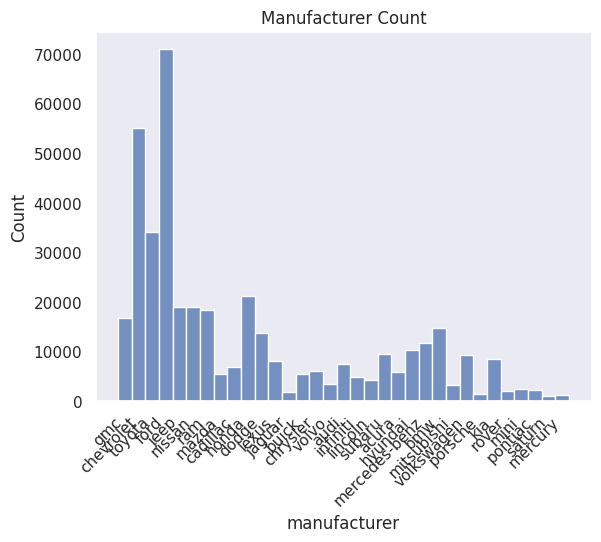

In [60]:
# Assuming vehicles is your DataFrame
sns.histplot(data=vehicles_clean["manufacturer"])
plt.title('Manufacturer Count')
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.show()

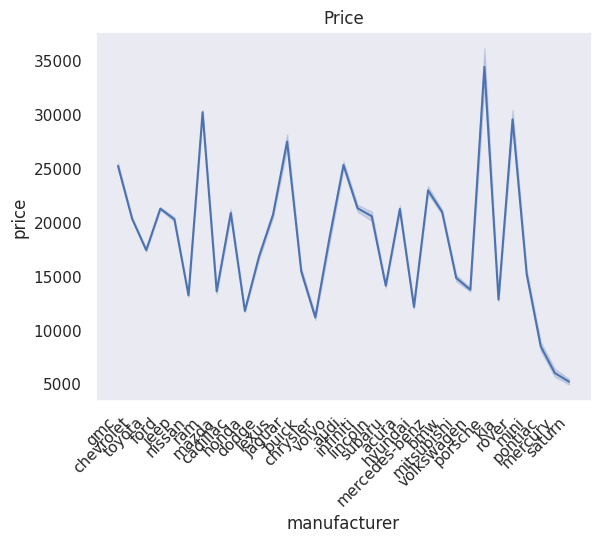

In [109]:
# Assuming vehicles is your DataFrame
sns.lineplot(x="manufacturer", y="price", data=vehicles_clean)
plt.title('Price')
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.show()

In [61]:
# Check the count of manufacturers after dropping
vehicles_clean["model"].value_counts()


f-150                      8009
silverado 1500             5140
1500                       4211
camry                      3135
silverado                  3023
                           ... 
evoke                         1
sante fe se                   1
telluridew                    1
sable wagon ls premium        1
Paige Glenbrook Touring       1
Name: model, Length: 29372, dtype: int64

In [98]:
# Clean the model names
vehicles_clean['model_clean'] = vehicles_clean['model'].str.lower().str.strip().str.split().str[0]
vehicles_clean = vehicles_clean.dropna()
print(vehicles_clean.info())

# Check the count of manufacturers after dropping
print(vehicles_clean["state"].value_counts())

vehicles_clean.to_csv("vehicles_clean.csv") 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172533 entries, 27 to 426878
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         172533 non-null  int64  
 1   year          172533 non-null  float64
 2   manufacturer  172533 non-null  object 
 3   model         172533 non-null  object 
 4   condition     172533 non-null  object 
 5   fuel          172533 non-null  object 
 6   odometer      172533 non-null  float64
 7   title_status  172533 non-null  object 
 8   transmission  172533 non-null  object 
 9   type          172533 non-null  object 
 10  paint_color   172533 non-null  object 
 11  state         172533 non-null  object 
 12  model_clean   172533 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 11.8+ MB
None
ca    19942
fl    12003
ny    10794
tx     9008
oh     7758
pa     6696
nc     6578
mi     6344
wi     5294
tn     4707
ma     4405
va     4282
il     4135
nj 

In [99]:
vehicles_clean = vehicles_clean.drop("model", axis = 1)

In [100]:
vehicles_clean = vehicles_clean.rename(columns={"model_clean": "model"})

In [102]:
#Dropping vehicles s with prices below $400.
vehicles_clean = vehicles_clean[(vehicles_clean['price'] > 1000)] 

# Price column statistics:
vehicles_clean["price"].describe()


count    162889.000000
mean      18882.876118
std       13283.189344
min        1012.000000
25%        7900.000000
50%       15999.000000
75%       27990.000000
max      290000.000000
Name: price, dtype: float64

In [103]:
vehicles_clean = vehicles_clean[(vehicles_clean['price'] < 80000)]
# Price column statistics:
vehicles_clean["price"].describe()

count    162651.000000
mean      18758.897898
std       12849.542258
min        1012.000000
25%        7900.000000
50%       15995.000000
75%       27990.000000
max       79999.000000
Name: price, dtype: float64

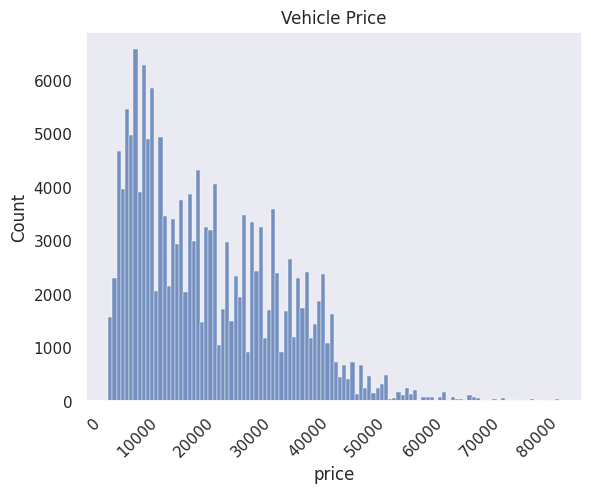

In [104]:
# APlotting vehicles  Prices
sns.histplot(data=vehicles_clean["price"])
plt.title('Vehicle Price')
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.show()

In [105]:
vehicles_clean["price"] = np.log(vehicles_clean["price"]) 

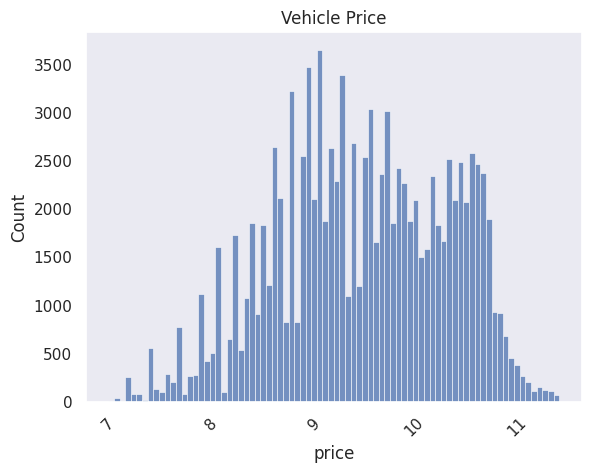

In [77]:
# APlotting vehicles  Prices
sns.histplot(data= vehicles_clean["price"])
plt.title('Vehicle Price')
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.show()

In [107]:
vehicles_clean["transmission"].value_counts()

automatic    109664
other         43963
manual         9024
Name: transmission, dtype: int64

In [108]:
vehicles_clean["title_status"].value_counts()

clean         156136
rebuilt         3767
salvage         1582
lien             952
missing          175
parts only        39
Name: title_status, dtype: int64

In [109]:
# Dropping all titles "rebuilt", "salvage", "lien", "missing", "parts only" because they are statiscally insignificant.
make_to_drop = ["rebuilt", "salvage", "lien", "missing", "parts only"]
vehicles_clean = vehicles_clean[~vehicles_clean['title_status'].isin(make_to_drop)]
vehicles_clean["title_status"].value_counts()

clean    156136
Name: title_status, dtype: int64

In [110]:
#Dropping the title status column since we only have one type left.
vehicles_clean = vehicles_clean.drop("title_status", axis = 1)

In [111]:
vehicles_clean.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 156136 entries, 27 to 426878
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         156136 non-null  float64
 1   year          156136 non-null  float64
 2   manufacturer  156136 non-null  object 
 3   condition     156136 non-null  object 
 4   fuel          156136 non-null  object 
 5   odometer      156136 non-null  float64
 6   transmission  156136 non-null  object 
 7   type          156136 non-null  object 
 8   paint_color   156136 non-null  object 
 9   state         156136 non-null  object 
 10  model         156136 non-null  object 
dtypes: float64(3), object(8)
memory usage: 9.5+ MB


In [134]:
#have to drop more columns due to ValueError: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.
columns_to_drop = ["model", "state"]
# Drop columns inplace 
vehicles_clean.drop(columns=columns_to_drop, inplace=True)



<class 'KeyError'>: "['model', 'state'] not found in axis"

In [135]:
vehicles_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156136 entries, 27 to 426878
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         156136 non-null  float64
 1   year          156136 non-null  float64
 2   manufacturer  156136 non-null  object 
 3   condition     156136 non-null  object 
 4   fuel          156136 non-null  object 
 5   odometer      156136 non-null  float64
 6   transmission  156136 non-null  object 
 7   type          156136 non-null  object 
 8   paint_color   156136 non-null  object 
dtypes: float64(3), object(6)
memory usage: 11.4+ MB


transmission_automatic   -0.430623
odometer                 -0.296546
fuel_gas                 -0.281049
condition_fair           -0.266221
type_sedan               -0.217192
                            ...   
condition_good            0.229507
fuel_other                0.263000
year                      0.485225
transmission_other        0.510237
price                     1.000000
Length: 75, dtype: float64


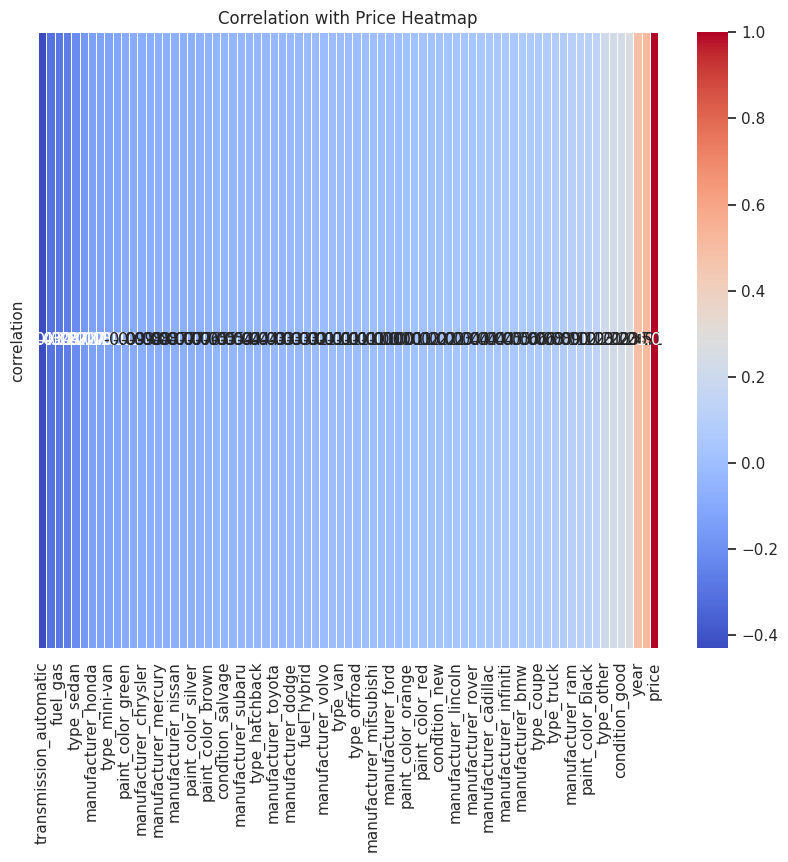

In [142]:
# One-hot encode categorical columns
vehicles_clean_encoded = pd.get_dummies(vehicles_clean)

# Calculate the correlation matrix between 'price' and all other columns
price_correlation = vehicles_clean_encoded.corrwith(vehicles_clean['price'])
price_correlation = price_correlation.sort_values(ascending=True)  # Sorting the correlations

# Printing the correlation of 'price' with other columns
print(price_correlation)

# Create a DataFrame with the correlation values
price_correlation_df = pd.DataFrame(price_correlation, columns=['correlation'])

# Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(price_correlation_df.transpose(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation with Price Heatmap')
plt.show()

In [141]:

# One-hot encode categorical columns
vehicles_clean_encoded = pd.get_dummies(vehicles_clean)

# Calculate the correlation matrix between 'price' and all other columns
price_correlation = vehicles_clean_encoded.corrwith(vehicles_clean['price'])
price_correlation.sort(ascending = True)

# Printing the correlation of 'price' with other columns
print(price_correlation)

# Create a DataFrame with the correlation values
price_correlation_df = pd.DataFrame(price_correlation, columns=['correlation'])

# Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(price_correlation_df.transpose(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation with Price Heatmap')
plt.show()

<class 'AttributeError'>: 'Series' object has no attribute 'sort'

In [114]:
# setting y as the price column and X as ever
y = vehicles_clean["price"]
X = vehicles_clean.drop("price", axis = 1)

In [121]:
# Using OneHotEncoder to transform non-numerical columns and concat X after.
columns = ["manufacturer", "condition", "fuel", "transmission", "type", "paint_color", "state", "model"] 

oh_encoded = oh_encoder.fit_transform(X[columns])

encoded_cols = oh_encoder.get_feature_names_out(columns)


encoded_df = pd.DataFrame(oh_encoded, columns=encoded_cols)
encoded_df = pd.DataFrame(oh_encoded, columns=encoded_cols)

X = pd.concat([X, encoded_df], axis=1) 

X = X.drop(columns=non_float_cols)

<class 'ValueError'>: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.